In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import streamlit as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

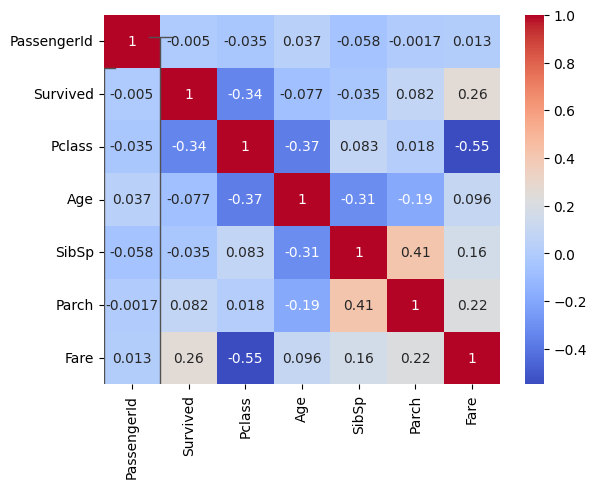

In [ ]:
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

train.info()
train.describe()
train.head()
train.isnull().sum()
test.isnull().sum()

sns.histplot(train['Age'], kde=True)
sns.boxplot(x='Survived',y='Age', data=train)
sns.heatmap(train.select_dtypes(include='number').corr(),annot=True,cmap='coolwarm')
plt.show()

print("\nEDA Observations:")
print("1. Most passengers are young adults.")
print("2. Younger passengers show higher survival probability.")
print("3. Fare has positive correlation with survival.")
print("4. Passenger class is negatively correlated with survival.")

In [ ]:
#Data Preprocessing

imputer = SimpleImputer(strategy='median')

train['Age']=train['Age'].fillna(train['Age'].median())
test['Age']=test['Age'].fillna(test['Age'].median())

passenger_ids = test['PassengerId']

combined = pd.concat([train,test], sort=False)
combined = pd.get_dummies(combined,columns = ['Sex','Embarked'],drop_first=True)
combined = combined.drop(['Name','Ticket','Cabin',],axis=1,errors='ignore')
train = combined[:len(train)]
test = combined[len(train):]


In [ ]:
X_train = train.drop(['Survived','SibSp','Parch','PassengerId'],axis=1,errors='ignore')
y_train = train['Survived']

X_test = test.drop(['Survived','SibSp','Parch','PassengerId'],axis=1,errors='ignore')

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#Train-Test Split
X_tr,X_te,y_tr,y_te = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_tr,y_tr)
y_pred = model.predict(X_te)

#Evaluation Metrics
print("\nAccuracy Score :",accuracy_score(y_te,y_pred))
print("\nPrecision Score :",precision_score(y_te,y_pred))
print("\nRecall Score :",recall_score(y_te,y_pred))
print("\nF1 Score :",f1_score(y_te,y_pred))



Accuracy Score : 0.7988826815642458

Precision Score : 0.7638888888888888

Recall Score : 0.7432432432432432

F1 Score : 0.7534246575342466


In [ ]:
# ROC-AUC Score
y_proba = model.predict_proba(X_te)[:,1]
roc_auc = roc_auc_score(y_te, y_proba)
print("\nROC-AUC Score :", roc_auc)

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_te, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Logistic Regression Coefficients Interpretation
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

coeff_df['Importance'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Importance', ascending=False)

print("\nLogistic Regression Coefficients (Interpretation):")
print(coeff_df)


In [5]:
y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId' : passenger_ids,
    'Survived' : y_test_pred
})
submission.to_csv('titanic_submission.csv',index=False)

joblib.dump(model,"titanic_model.pkl")
model = joblib.load("titanic_model.pkl")

st.title("Titanic Survival Prediction")

Pclass = st.selectbox("Passenger Class (1=1st,2=2nd,3=3rd)",[1,2,3])
Age = st.number_input("Age",0,100,25)
Fare = st.number_input("Fare",0,600,100)
Sex_male = st.selectbox("Gender",["Male","Female"])
Embarked_Q = st.selectbox("Embarked Port (Q/S)", ["S", "Q"])
Embarked_S = 1 if Embarked_Q == "S" else 0
Sex_male = 1 if Sex_male == "Male" else 0


input_data = pd.DataFrame({
    'Pclass' : [Pclass],
    'Age' : [Age],
    'Fare' : [Fare],
    'Sex_male' : [Sex_male],
    'Embarked_Q' : [1 if Embarked_Q == "Q" else 0],
    'Embarked_S' : [Embarked_S]
})

if st.button("Predict Survival") :
    prediction = model.predict(input_data)
    st.success("Survived" if prediction == 1 else "Did not survive")

    

2025-11-07 11:28:47.433 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.361 
  command:

    streamlit run C:\Users\Aarush\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-07 11:28:49.363 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.366 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.367 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 11:28:49.371 Thread 'MainThread': m